In [1]:
%matplotlib inline

import spiceypy as spice
import numpy as np
import matplotlib.pyplot as plt

import glob
import datetime

In [2]:
# load all kernels
kernels = [f for f in glob.glob('ephem/*') if not f.endswith('.sh')]
spice.furnsh(kernels)
kernels

['ephem/naif0012.tls',
 'ephem/pck00010.tpc',
 'ephem/de430.bsp',
 'ephem/gm_de431.tpc']

In [3]:
# determine ET now
import datetime 

def current_et():
    """ returns the current time in TDB """
    # determine UTC time in ISO 8601 format
    # outputs: 2019-12-14T00:35:35.119520+00:00
    now = datetime.datetime.now(datetime.timezone.utc)
    utc_time = now.isoformat()
    assert utc_time.endswith('+00:00')
    assert utc_time.find('T') > 0

    # convert ISO 8601 format to a string SPICE can parse
    # outputs: 2019-12-14 00:35:35.119520 UTC
    date, time_pz = utc_time.split('T')
    time = time_pz[:-6]
    spice_time = date + ' ' + time + ' UTC'

    # convert SPICE time to seconds past J2000
    et = spice.str2et(spice_time)
    return et

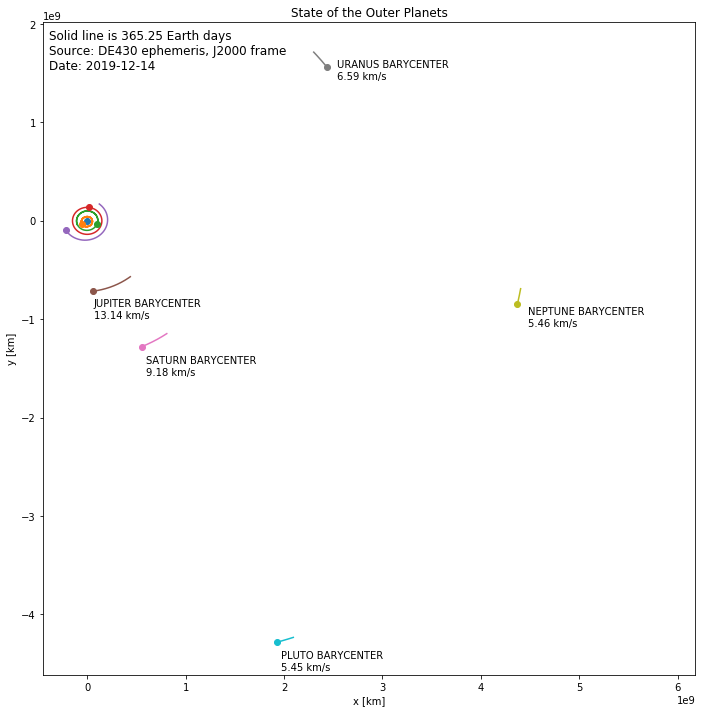

In [4]:
# plot position
et = current_et()
ets = np.linspace(et, et+365.25*1.0*spice.spd(), 365)
naif_ids = [10, 199, 299, 399, 4, 5, 6, 7, 8, 9]
mfac = {
    10: 1.1, 
    199: 1.1, 
    299: 1.1, 
    399: 1.1, 
    4: 2.0, 
    5: 1.1, 
    6: 1.07, 
    7: 1.045, 
    8: 1.025, 
    9: 1.02
}

def inner(naif_id):
    """ returns true if inner planet or the sun"""
    return (naif_id in [0,1,2,3,4,10,199,299,399,499])

fig = plt.figure(figsize=(2*8,2*6))
leg_handles = []
for naif_id in naif_ids:
    # determine state over a bit of time
    targ = spice.bodc2n(naif_id)
    obs = 'SOLAR SYSTEM BARYCENTER'
    state, lt = spice.spkezr(targ, ets, 'J2000', 'NONE', obs)
    state = np.vstack(state)
    avg_speed = np.linalg.norm(state[:,3:], axis=1).mean()
    
    # plot the position over time
    plt.plot(state[:,0], state[:,1], zorder=1)
    
    # only label the outer planets
    if not inner(naif_id):
        # outer planet
        plt.scatter(state[0,0], state[0,1], zorder=2)
        plt.text(mfac[naif_id]*state[0,0], mfac[naif_id]*state[0,1], 
                 '{}\n{:.2f} km/s'.format(targ, avg_speed), 
                 verticalalignment='top')
    else:
        # inner planet
        plt.scatter(state[0,0], state[0,1], label=targ, zorder=2)
        #plt.text(mfac[naif_id]*state[0,0], mfac[naif_id]*state[0,1], targ, verticalalignment='top')

# set plot options
plt.axis('square')
plt.xlabel('x [km]')
plt.ylabel('y [km]')
plt.title('State of the Outer Planets')
#plt.grid()
#plt.legend()

# description
ax = fig.gca()
plt.text(0.0+0.01, 1.0-0.01, '\n'.join(['Solid line is {0:.2f} Earth days'.format((ets[-1] - ets[0])/spice.spd()),
                               'Source: DE430 ephemeris, J2000 frame', 
                               'Date: ' + spice.timout(ets[0], 'YYYY-MM-DD')]),
         fontsize=12,
         horizontalalignment='left',
         verticalalignment='top',
         transform=ax.transAxes)

plt.show()

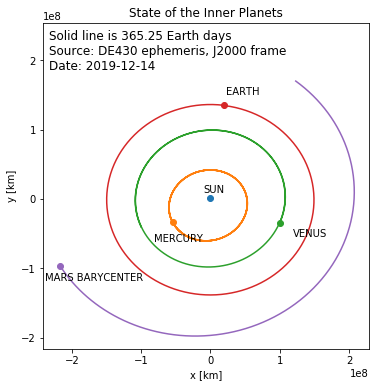

In [5]:
# plot position
et = current_et()
ets = np.linspace(et, et+365.25*12.0/12.0 *spice.spd(), 365)
naif_ids = [10, 199, 299, 399, 4]
mfac = {
    10: 20, 
    199: 1.5, 
    299: 1.2, 
    399: 1.2, 
    4: 1.1
}

fig = plt.figure(figsize=(1.0*8,1.0*6))
for naif_id in naif_ids:
    # determine state over a bit of time
    targ = spice.bodc2n(naif_id)
    obs = 'SOLAR SYSTEM BARYCENTER'
    state, lt = spice.spkezr(targ, ets, 'J2000', 'NONE', obs)
    state = np.vstack(state)
    avg_speed = np.linalg.norm(state[:,3:], axis=1).mean()
    
    # plot the position over time
    plt.plot(state[:,0], state[:,1], zorder=1)
    
    # label everything
    if inner(naif_id):
        # inner
        plt.scatter(state[0,0], state[0,1], label=targ, zorder=2)
        plt.text(mfac[naif_id]*state[0,0], mfac[naif_id]*state[0,1], 
                 '{}'.format(targ),
                 verticalalignment='top')

# set plot options
plt.axis('square')
plt.xlabel('x [km]')
plt.ylabel('y [km]')
plt.title('State of the Inner Planets')
#plt.grid()
#plt.legend()

# description
ax = fig.gca()
plt.text(0.0+0.02, 1.0-0.02, '\n'.join(['Solid line is {0:.2f} Earth days'.format((ets[-1] - ets[0])/spice.spd()),
                               'Source: DE430 ephemeris, J2000 frame', 
                               'Date: ' + spice.timout(ets[0], 'YYYY-MM-DD')]),
         fontsize=12,
         horizontalalignment='left',
         verticalalignment='top',
         transform=ax.transAxes)

plt.show()